## Matched Filtering in Action for Real LIGO Data
This tutorial is based on [Tutorial 2.2](https://github.com/gw-odw/odw-2020/blob/master/Day_2/Tuto_2.2_Matched_Filtering_In_action.ipynb) from the GW Open Data Workshop \#3.

We will be using the [PyCBC](http://github.com/ligo-cbc/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how find a specific signal in LIGO data. To start off, we will learn about the underlying concept behind matched-filtering--the cross-correlation. Finally, we will use prebuilt PyCBC methods to perform the matched filtering using real LIGO data around the first detection, GW150914.

## Installation (execute only if running on a cloud platform!)

In [1]:
# -- Use the following for Google Colab
#! pip install pycbc lalsuite

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### The cross-correlation
Before we talk about matched fitering in the context of gravitational-waves, we will introduce another signal processing concept: the cross-correlation. For two disrete data sets $h_{t}$ and $g_t$, it is defined as:
$$ CC_j = \sum_{t} g_{t}^{*}h_{t+j}.$$
The * symbol denotes complex conjugation, where the imaginary part of the signal switches sign:
$$x = 3+5i, \quad x^* = 3-5i.$$
The cross-correlation basically tells you how similar two data sets are as a function of the offset between them. So for example, if $g_t$ is a short signal that is contained at some time $j$ within $h_t$, the cross-correlation will be maximized at $j$. Let's look at a quick example of cross-correlation before applying it to gravitational-wave data:

In [3]:
g = [1,2,3]
h = [0, 1, 0.5]
cc = np.sum(np.multiply(h,g))
print(cc)
print(g[0]*h[0]+g[1]*h[1]+g[2]*h[2])

3.5
3.5


In this example, the two data sets $g_t$ and $h_t$ have the same number of elements, so we cannot shift them relative to each other. This means our cross-correlation is only valid for one point $j=0$ in the equation above. What if we look at arrays of different lengths?

In [4]:
g = [1,2]
h = [0, 1, 0.5, 1, 2, 0.46, 7]
n_shift = len(h)-len(g)
print(n_shift)
cc = []
for i in range(n_shift+1):
    cc.append(np.sum(np.multiply(h[i:i+len(g)],g)))
print(cc)
cc2 = np.correlate(h, g)
print(cc2)

5
[2, 2.0, 2.5, 5, 2.92, 14.46]
[ 2.    2.    2.5   5.    2.92 14.46]


Here is a visualization of the operations being performed during the cross-correlation. The shorter signal (red curve) is being shifted across the longer signal (blue curve). The red curve is $g_{t}$ in the expression above, and the blue curve is $h_{t}$. As the peak of the red slides into the blue, the cross-correlation increases, since the two signals start to match each other more closely. While the red is entirely inside the blue, the cross-correlation is unchanged since the match is the same, and then it decreases as the red slides out of the blue. ![](https://thumbs.gfycat.com/BrownQuickIsabellineshrike-small.gif)

And let's look at the example above but make the data sets $h_t$ and $g_t$ complex:

In [5]:
g = [1+5j,2+1j]
h = [0, 1+1j, 0.5-0.3j, 1, 2+3j, 0.46+0.67j, 7-0.83j]
n_shift = len(h)-len(g)
cc = []
for i in range(n_shift+1):
    cc.append(np.sum(np.multiply(h[i:i+2],np.conjugate(g))))
print(cc)
cc2 = np.correlate(h, g)
print(cc2)

[(3+1j), (6.7-5.1j), (1-3.8j), (8-1j), (18.59-6.12j), (16.98-10.290000000000001j)]
[ 3.   +1.j    6.7  -5.1j   1.   -3.8j   8.   -1.j   18.59 -6.12j
 16.98-10.29j]


### Looking for a specific signal in the data

The cross-correlation is the key tool for matched filtering, since it will show us a spike at the time that the signal and the template ($h_t$ and $g_t$ in the example above) have the best "match". In this way, the cross-correlation is a proxy for the signal-to-noise ratio, or SNR. If you know what signal you are looking for in the data, then matched filtering is known to be the optimal method to extract the signal. Even when the parameters of the signal are unkown, you can perform the matched filtering and calculate the SNR for a range of different parameter values across the space of interest, and the template that maximizes the SNR will be the one with the parameters closest to the signal.

### Preconditioning the data 
 
Since we are using real LIGO data, we need to precondition it before trying to perform the matched filtering to supress low frequency behavior which can introduce numerical artefacts. We will use a **high-pass** filter to remove frequency content below 15 Hz, where we know the LIGO data is affected by seismic noise. We may also wish to reduce the sample rate of the data if high frequency content is not important. PyCBC contains an interface to the online catalog of gravitational-wave data and events, so you can easily access the data and parameters of the published gravitational-wave signals. We will use PyCBC to access the data rather than `gwpy` as we did previously, since it allows for an easier interface with the waveform template.

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


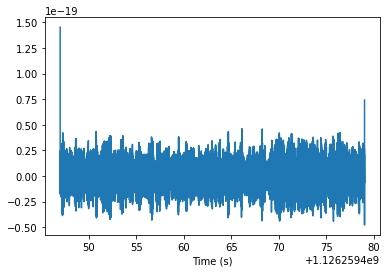

In [6]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

# As an example we use the GW150914 data
merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

plt.plot(strain.sample_times, strain)
plt.xlabel('Time (s)')
plt.show()

#### Filter wraparound 

Note the spike in the data at the boundaries. This is caused by the highpass filter applied to the data. When the filter is applied to the boundaries, it wraps around to the beginning of the data. This causes issues becasue the data are not periodic. To avoid this, we trim the ends of the data sufficiently to remove the spikes.

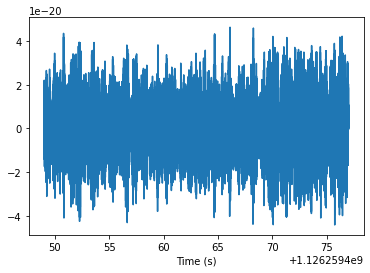

In [7]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

plt.plot(conditioned.sample_times, conditioned)
plt.xlabel('Time (s)')
plt.show()

### Calculate the power spectral density
In order to determine how loud the signal is relative to the noise, we need a way to characterize the level of the noise in the interferometer. To do this, we use the PSD. We can use the built-in method from PyCBC to do this, as we did with `gwpy` before. Since we are using real data, we need to apply some extra conditioning steps to make sure the PSD is well-behaved.

In [8]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

Add a cell below and plot the PSD to make sure it looks as expected. The x coordinates for this plot should be the frequencies, which you can access via `psd.sample_frequencies`, and the y coordinates are the `psd`. What is happening at low frequencies?

### Create the template
As we saw above, matched filtering involves computing the cross-correlation between the potential signal, or template, and the data by sliding the template across the data and summing over the product of the two.
If there is a signal in the data that aligns with the template, you will get a large value of the cross-correlation. Let's use PyCBC to calculate our template waveform.

In [9]:
from pycbc.waveform import get_td_waveform
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the cross-correlation
# for each one.

# We'll assume equal masses, and non-rotating black holes which is within the posterior probability
# of GW150914. 
m = 36 # Solar masses
hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

When we first looked at waveforms, we learned that the merger of the two black holes occurs approximately at the time corresponding to the maximum amplitude of the waveform. If we were to use the waveform as we have calculated it above, the peak of the cross-correlation will occur at the time corresponding to the _start_ of the signal hidden in the data rather than the merger time. To get a better estimate of the merger time instead of the start of the signal, we need to shift the location of the merger to the start of the template. We do this below using the `cyclic_time_shift` method.

Text(0, 0.5, 'h(t)')

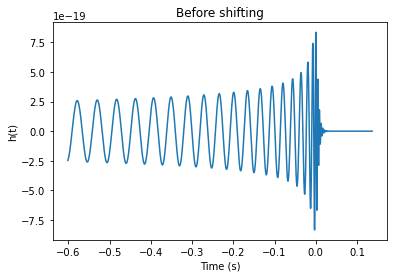

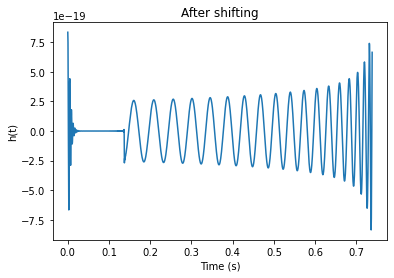

In [10]:
plt.figure()
plt.title('Before shifting')
plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)')
plt.ylabel('h(t)')

template = hp.cyclic_time_shift(hp.start_time)

plt.figure()
plt.title('After shifting')
plt.plot(template.sample_times, template)
plt.xlabel('Time (s)')
plt.ylabel('h(t)')

### Whiten the data and template
The final pre-processing step needed before performing matched filtering on the data by taking the cross-correlation is to **whiten** both the data and the template. This means that we divide it by the square root of the PSD in the frequency domain, then transform back to the time domain. We use the `to_frequencyseries` method to convert the template and data to the frequency domain, divide by the PSD, and then use to `to_timeseries` method to go back to the time domain.

In [11]:
# whiten the data and the template
conditioned_whitened = (conditioned.to_frequencyseries() / np.sqrt(psd)).to_timeseries()
conditionedn = conditioned_whitened.numpy()

# The PSD, sampled properly for the signal
psd_template = interpolate(psd, template.delta_f)

template_whitened = (template.to_frequencyseries() / np.sqrt(psd_template[:-1])).to_timeseries()
templaten = template_whitened.numpy()

Add a cell below and plot the whitened data. How is it different than before we whitened it? Hint: Look carefully at the y axis labels.

### Calculating the cross-correlation and signal-to-noise time series
Now we will use the tools we developed in the simple examples at the beginning of this notebook to calculate the cross-correlation between the data and the template. In order to convert the cross-correlation to SNR, we can use the following formula:   
`snr = np.absolute(cross_correlation)/np.std(cross_correlation)`  
Because we calculate the SNR for the whole time segment we are considering, this is called the **SNR timeseries**.

We found a signal at 1126259463.573723007s with SNR 13.063504750814415


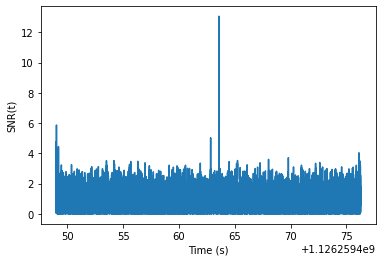

In [12]:
# Calculate the cross-correlation, times, and SNR
cc = np.correlate(templaten, conditionedn)
n_shift = len(conditionedn) - len(templaten)
dt = conditioned.delta_t
start_time = conditioned.start_time
times = np.arange(start_time, start_time + n_shift*dt + dt, dt)
snr = np.absolute(cc)/np.std(cc)

# Plot the SNR timeseries
plt.plot(times, snr)
plt.xlabel('Time (s)')
plt.ylabel('SNR(t)')
peak = np.argmax(snr)
print("We found a signal at {}s with SNR {}".format(times[peak], snr[peak]))

### Using PyCBC to calculate the SNR timeseries
It turns out that there is a handy PyCBC function that can calculate the SNR timeseries for us, which does the whitening and cross-correlation under the hood. The only difference from above is that the template needs to be the same size as the data, rather than shorter. We can get around this by "resizing" the template to match the data length. This amounts to adding a bunch of zeros after the end of the actual template.

In [13]:
from pycbc.filter import matched_filter, matched_filter_core
from pycbc.types import TimeSeries as ts_pycbc
from pycbc.types import FrequencySeries as fs_pycbc

# Make our new, longer template
hp2, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)
hp2.resize(len(conditioned))
template2 = hp2.cyclic_time_shift(hp2.start_time)

# Calculate the SNR
snr = matched_filter(template2, conditioned, psd=psd, low_frequency_cutoff=20)

Now let's plot the SNR timeseries that PyCBC computed for us. Looking at our plot of the SNR timeseries above, we can also see some spikes at times near the beginning and end of the segment. These are artifacts from filtering that we can safely remove. We also need to take the absolute value like we did above, since PyCBC doesn't do this step automatically.

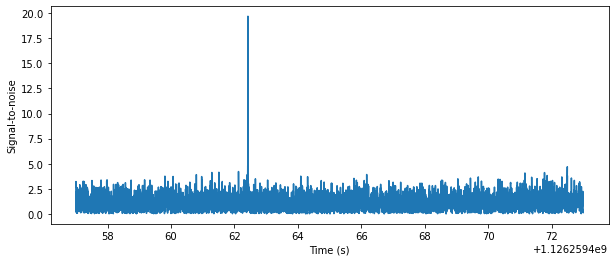

We found a signal at 1126259462.4248047s with SNR 19.678977177701515


In [14]:
# Remove edge times
snr = snr.crop(4 + 4, 4)

# Take absolute value and plot
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = np.argmax(abs(snr))
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

How do the time and SNR of the peak calculated with PyCBC compare with what we calculated above? The times match to within about a second, but the SNR calculated by PyCBC is higher. There are some extra corrections that need to be taken into account for properly normalizing the calculation and aligning the template and waveform. For this reason, we'll use the PyCBC version from now on.

### Aligning and visualizing the overlap between the signal and data

In the previous section we found a peak in the signal-to-noise timeseries for a proposed binary black hole merger. We can use this SNR peak to align our template to the data in order to visualize how well it matches the data.

In [15]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - start_time
aligned = template2.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = start_time

To compare the data and signal on equal footing, and to concentrate on the frequency range that is important, we will whiten both the template and the data, and then **bandpass** both the data and template between 30-300 Hz. This just means that we will remove frequencies outside this range. As such, any signal that is in the data is transformed in the same way that the template is.

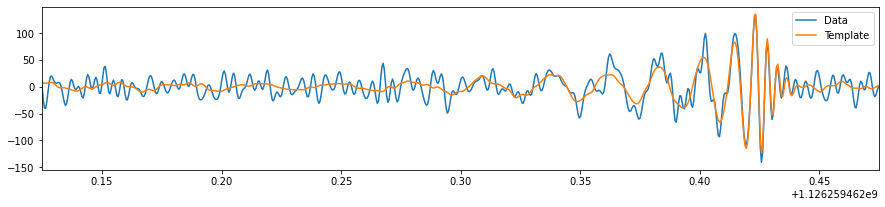

In [16]:
# Whiten the template like we already did for the data above
white_template = (aligned.to_frequencyseries() / np.sqrt(psd)).to_timeseries()

# Remove excess frequencies
white_data = conditioned_whitened.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data, label="Data")
plt.plot(white_template.sample_times, white_template, label="Template")
plt.xlim(time-0.3, time+0.05)
plt.legend()
plt.show()

We can actually see the signal by eye in the whitened data for GW150914 once we've properly processed the data and zoomed in close to the merger! It matches very closely with the whitened signal. The extra wiggles in the blue are just due to noise fluctuations. 

## Challenge!

Use the methods demonstrated above to see if you can calculate the SNR
time series in the following data sets. What is the SNR of each signal?
Which template matched best to which data?

Information that may be useful:

* Signals are all placed between 100 and 120 seconds into the frame file.
* You may assume mass1 = mass1 (equal mass) and that each component mass is one of 15, 30, or 45.
* Each file starts at gps time 0, and ends at gps time 128
* The channel name in each file is "H1:TEST-STRAIN"

In [ ]:
# Download the challenge set files
from pycbc.frame import read_frame
import urllib

def get_file(fname):
    url = "https://github.com/gw-odw/odw-2020/raw/master/Data/{}"
    url = url.format(fname)
    urllib.request.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_1.gwf', 'PyCBC_T2_2.gwf']

for fname in files:
    get_file(fname)    

# An example of how to read the data from these files:
file_name = "PyCBC_T2_0.gwf"

# A channel name is needed since often `gwf` files contain 
# many different data sets.
channel_name = "H1:TEST-STRAIN"

start = 0
end = start + 128

# This will be a pycbc timeseries object already, so you
# don't need to covert from gwpy to pycbc as we did above
ts = read_frame(file_name, channel_name, start, end)